# Quantile based cluster segmentation

This is a data exploration project that aims at defining a quintile based criterion for customer segmentation based on the **RFM** parameter.\
Data have already been aggregated and **RFM** parameters extracted. The reference time period is a solar year starting from `01-01-2021` to `31/12/2021`

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# load the dataframe
df = pd.read_csv("/home/andrea/Documents/Develop/rs2022-rfm/data/rfm_g_2020_09_01.csv",
                 delimiter=";");
QTL = 99

## Database inspection

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725862 entries, 0 to 725861
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   codice_cliente  725862 non-null  int64  
 1   recency         725862 non-null  int64  
 2   frequency       725862 non-null  int64  
 3   monetary        725862 non-null  float64
 4   tmin            725862 non-null  float64
 5   tmax            725862 non-null  float64
 6   tmed            725862 non-null  float64
 7   tdev            641501 non-null  float64
 8   dt_min          725862 non-null  object 
 9   dt_max          725862 non-null  object 
 10  t_days_op       725862 non-null  int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 60.9+ MB


In [4]:
df.head()

codice_cliente  recency  frequency  monetary   tmin    tmax       tmed  \
0           39018        4        199  17109.79 -58.08  784.80  85.978844   
1           39020      288          1     38.83  38.83   38.83  38.830000   
2           39026      205          4     29.76   4.42   11.50   7.440000   
3           39032       10         56   3052.51   6.01  166.23  54.509107   
4           39037       29         16    896.14  15.51  102.37  56.008750   

         tdev      dt_min      dt_max  t_days_op  
0  103.708091  2021-01-02  2021-12-28        360  
1         NaN  2021-03-19  2021-03-19          0  
2    3.107893  2021-02-06  2021-06-10        124  
3   32.959800  2021-01-05  2021-12-22        351  
4   23.022172  2021-01-12  2021-12-03        325

In [5]:
df.describe()

codice_cliente        recency      frequency       monetary  \
count    7.258620e+05  725862.000000  725862.000000  725862.000000   
mean     9.995405e+05      60.307867      28.508570     872.407637   
std      5.011536e+05      86.069130      74.667618    2073.999860   
min      3.901800e+04       1.000000       1.000000    -102.730000   
25%      5.934672e+05       4.000000       4.000000     105.170000   
50%      1.059082e+06      16.000000      12.000000     358.060000   
75%      1.459619e+06      85.000000      35.000000    1076.517500   
max      1.861455e+06     364.000000   26420.000000  792806.840000   

                tmin           tmax           tmed           tdev  \
count  725862.000000  725862.000000  725862.000000  641501.000000   
mean       13.373528      78.003314      35.877081      21.099763   
std        27.486545      75.993709      31.785732      21.520541   
min     -2032.910000     -10.000000     -34.243333       0.000000   
25%         3.180000      37.560000      18.216262      10.388107   
50%         6.710000      64.460000      28.740000      16.942087   
75%        14.900000     102.710000      44.928027      26.799347   
max      9087.000000   30955.020000    9087.000000    7501.354153   

           t_days_op  
count  725862.000000  
mean      224.485999  
std       135.820492  
min         0.000000  
25%        92.000000  
50%       283.000000  
75%       347.000000  
max       364.000000

### Dataframe straucture
The dataframe is **725862** by **11** and contains the following parameters:\
1. `Codice_cliente`: unique client identifier\
2. `recency`: Number of days since last purchase\
3. `frequency`: number of time the client visited the store\
4. `monetary`: total amount of money spent in the reference time period\
5. `tmin`: minimum amount of money spent by the client\
6. `tmax`: maximum spent by the client\
7. `tmed`: average money spent\
8. `tdev`: standardc deviation of tmed\
9. `dt_min`: first day the client visited the store in the reference period\
10. `dt_max`: last day the client visited the store\
11. `t_days_op`: differnece between the first day of visit and the last one\

<!-- <ol>
    <li> <b>`Codice_cliente`</b>: unique client identifier</li>
    <li> <b>recency</b>: Elapsed dauys since last purchase</li>
    <li> <b>frequency</b>: number of time the client visited the store</li>
    <li> <b>monetary</b>: total amount of money spent in the reference time period</li>
    <li> <b>tmin</b>: minimum amount of money spent by the client</li>
    <li> <b>tmax</b>: maximum spent by the client</li>
    <li> <b>tmed</b>: average money spent</li>
    <li> <b>tdev</b>: standardc deviation of tmed</li>
    <li> <b>dt_min</b>: first day the client visited the store in the reference period</li>
    <li> <b>dt_max</b>: last day the client visited the store</li>     
    <li> <b>t_days_op</b>: differnece between the first day of visit and the last one</li>
</ol> -->

Inspecting the summary statistic of the database it can be noticed that the parameters `dt_min` and `dt_max` are of type as string instead of datetime.\
Also the tdev columns appears to have some `NaNs` in it. This values correspond to customers who have made a single purchase in the reference time period, thus their deviation form the mean is 0.\
We will deal with these values when we will discuss outliers further down in the analisys.

In [6]:
# Convert date from string to datetime
df['dt_min']= pd.to_datetime(df['dt_min'])
df['dt_max']= pd.to_datetime(df['dt_max'])
# (df.dt_max.max() - df.dt_min.min()).days ## 364 days from 01/01/2021 to 31/12/2021

Another interesting observation comes from the variables `tmin`, `tmax` and `monetary`.\
These are supposed to report the amount of money spent in the store.\
However some of their entries are negative. Negative transactions could correspond to returned items or to human errors made at the counter.\
Either way these values could be safely removed without compromising the analysis.

In [7]:
df = df[ (df['tmax'] > 0) & (df['monetary'] > 0)]
# Maybe I should change this with logical OR

### RFM parameters inspection
#### Monetary (**M**)
**Monetary** is the the most intuitive parameter. It's the total amount of money spent by the client in the reference time period.
It is stored in the table as a single variable of class float and its distribution and range are shown in the following figures.

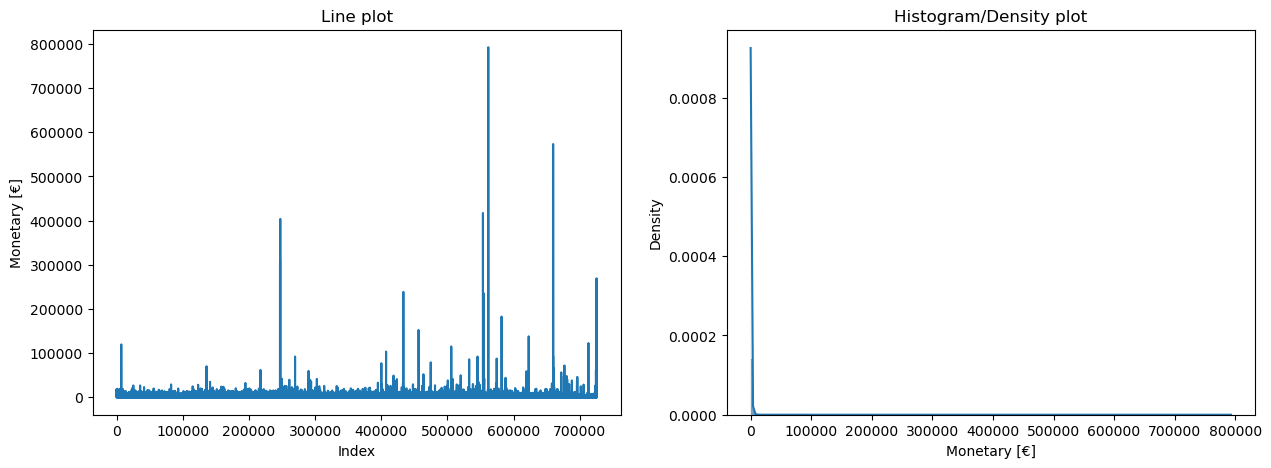

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(df['monetary'])
ax1.set(xlabel='Index', ylabel="Monetary [€]")
ax1.set_title('Line plot')

sns.histplot(ax=ax2, x=df['monetary'], kde=True, stat="density", binwidth=1000)
ax2.set(xlabel='Monetary [€]', ylabel="Density")
ax2.set_title('Histogram/Density plot')
plt.show()

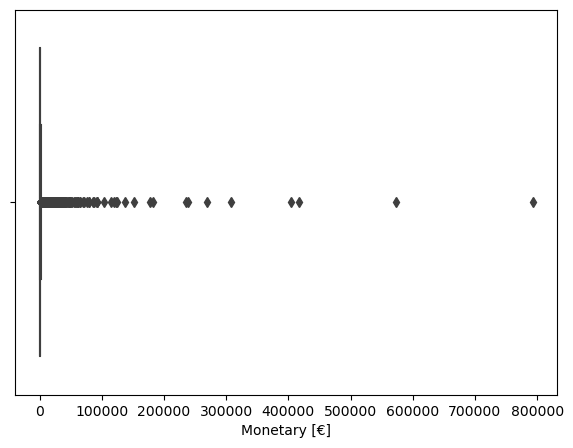

In [9]:
fig, ax = plt.subplots(figsize=(7,5))
sns.boxplot(ax=ax, x=df["monetary"])
ax.set(xlabel='Monetary [€]')
plt.show()
plt.close()

From the plot it is evident that the `monetary` variable has some very strong outliers.\
By far the largest portion of data is localized around the first few hundred values.\
The spike-like feature in the line plot indicated that there are several clients whose monetary value is of several order of magnitude higher then the regula distribution.\
This behavior is further emphasized by the histogram which shows a heavy right skewed tail.\
The monetary summary table shows that the largest amount of money spent in a year is over 700k Euros (see also line plot), but also that 75% of the data is below 1000Euros.

#### Frequency (**F**)
Frequency is an interesting parameter. It represents the number of times a client has visited the store.\
Unlinke monetary, fruequency is stored as an integer variable. It's minimum value is 1 for a clients who only visted the store in the reference time to period to optimally 364 for a very loyal customers who visit the store every single day.\
The distribution of the parameter is shown in the following figures.\

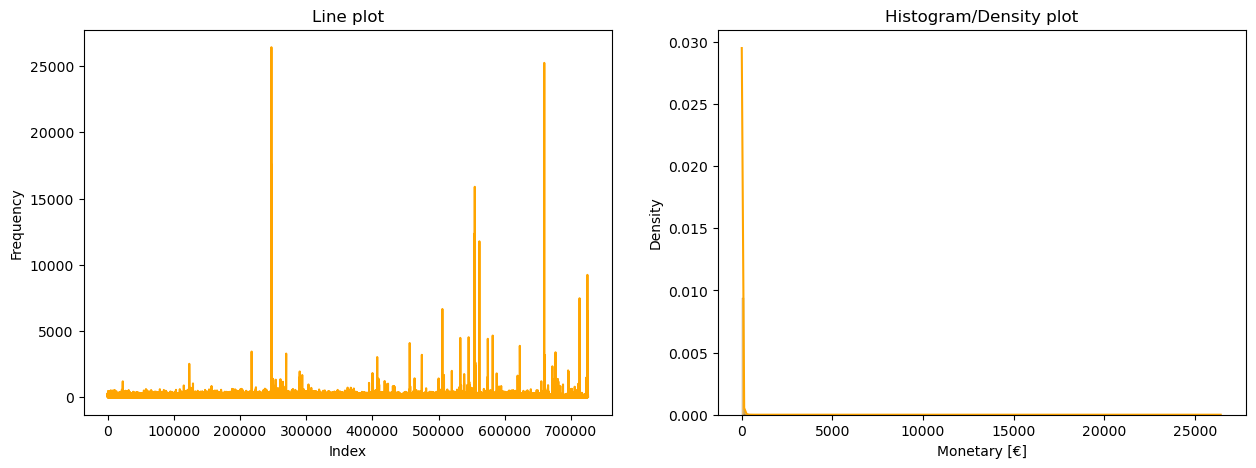

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(df['frequency'], color='orange')
ax1.set(xlabel='Index', ylabel="Frequency")
ax1.set_title('Line plot')

sns.histplot(ax=ax2, x=df['frequency'], kde=True, stat="density", binwidth=100, color='orange')
ax2.set(xlabel='Monetary [€]', ylabel="Density")
ax2.set_title('Histogram/Density plot')
plt.show()

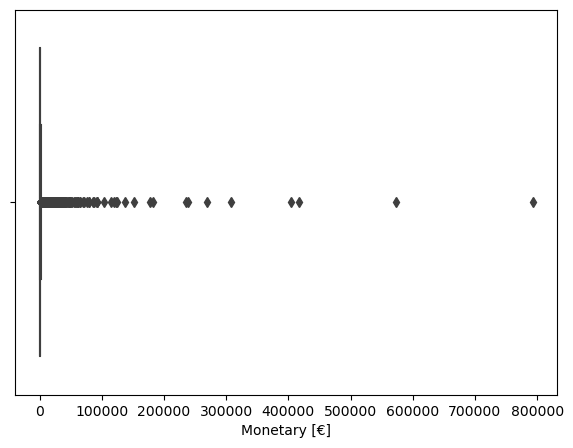

In [11]:
fig, ax = plt.subplots(figsize=(7,5))
sns.boxplot(ax=ax, x=df["monetary"])
ax.set(xlabel='Monetary [€]')
plt.show()
plt.close()

As already seen for the monetary, we notice the presence of strong outliers, topping up to more than 25000 visit in year (line plot).\
This is also reflectd in the histogram where we see a strongly skewed right-tail.\
Also the boxplot confirms that almost the entirety of the data is clustered around low values.\
Inspecting the summary table for the frequency we notice that the 75th percentile is at 35.

## Recency (**R**)
Recency is the measure of the number of days that have passed since the last purchase.\
Its values are by definition defined in the range 1 to 364.\
For this reason, it is not a well suiteed parameter to explore for outlier detection analysis.\
Furthermore its valor in the context of customer segmetation strategy can be questioned due to its simplidistic definition.\
A customers who has visited the store twice in a year, on the first and on the last day of the year, has the same recency of a customer who has gone shopping every day.

# Percentile cut-off (90, 95, 99)

In the following section it is reported a data exploration method in in which a percentile based removal strategy is employed to account for outliers in the data.\
In the specific we set a percentile cutoff value of 99%, thus discarrding the top 1% of extreme values out of our analysis.\
This value is purely subejective and does not necessarely represents the best mean to isolate the outliers.\
It is however based on the evidence tha both moentary and frequency have a discrete portion of extreme values which will hopefully be cutoff.\
It is however a sounded method and should remove a large part of the outliers, as we have notice that most of the them tend to have very strong values.

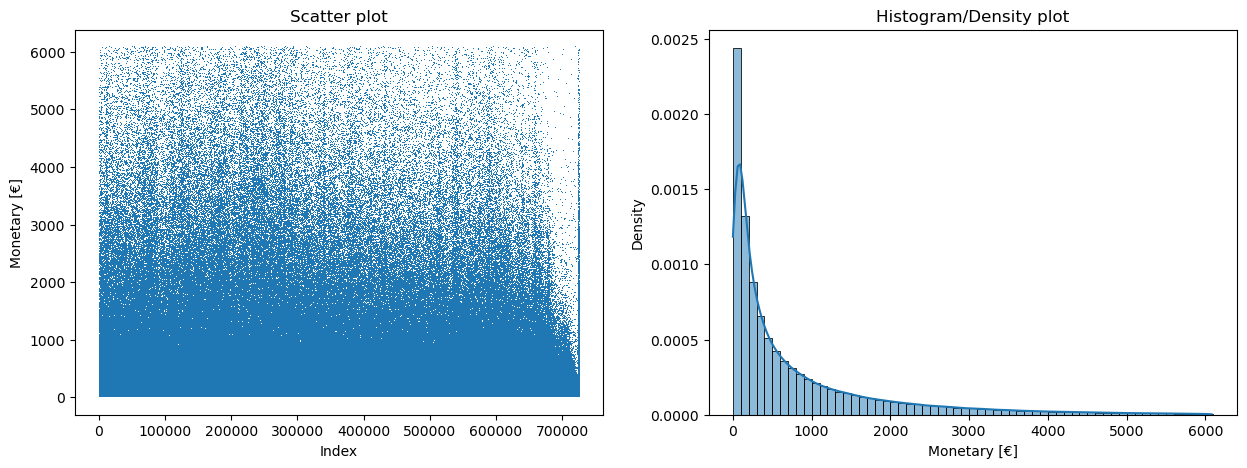

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(df['monetary'][df['monetary'] < np.percentile(df['monetary'], QTL)], ',')
ax1.set(xlabel='Index', ylabel="Monetary [€]")
ax1.set_title('Scatter plot')

sns.histplot(ax=ax2, x=df['monetary'][df['monetary'] < np.percentile(df['monetary'], QTL)], kde=True, stat="density", binwidth=100)
ax2.set(xlabel='Monetary [€]', ylabel="Density")
ax2.set_title('Histogram/Density plot')
plt.show()
plt.close()

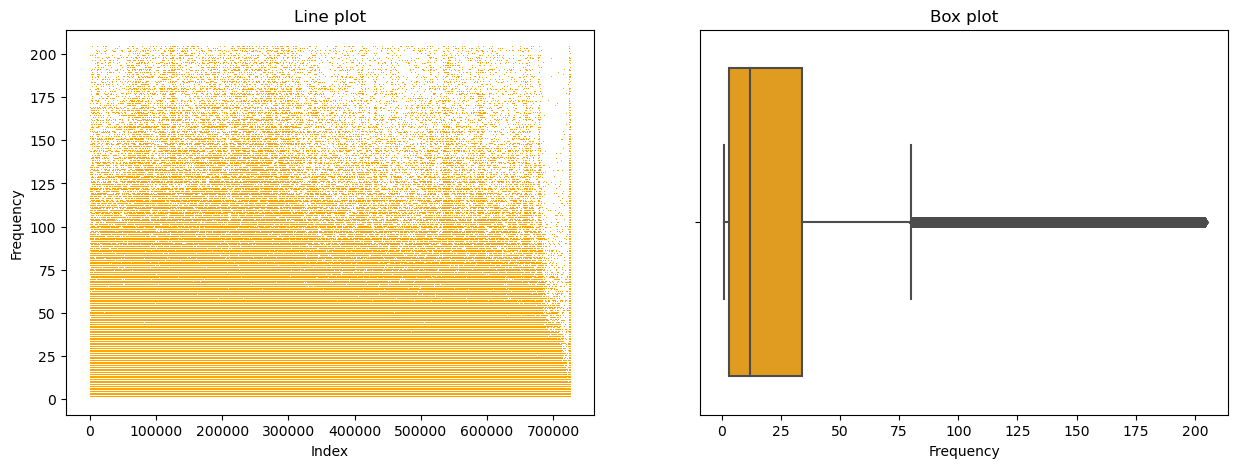

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(df['frequency'][df['frequency'] < np.percentile(df['frequency'], QTL)], ',', color='orange')
ax1.set(xlabel='Index', ylabel="Frequency")
ax1.set_title('Line plot')

sns.boxplot(ax=ax2, x=df['frequency'][df['frequency'] < np.percentile(df['frequency'], QTL)], color='orange')
ax2.set(xlabel='Frequency')
ax2.set_title('Box plot')
plt.show()
plt.close()

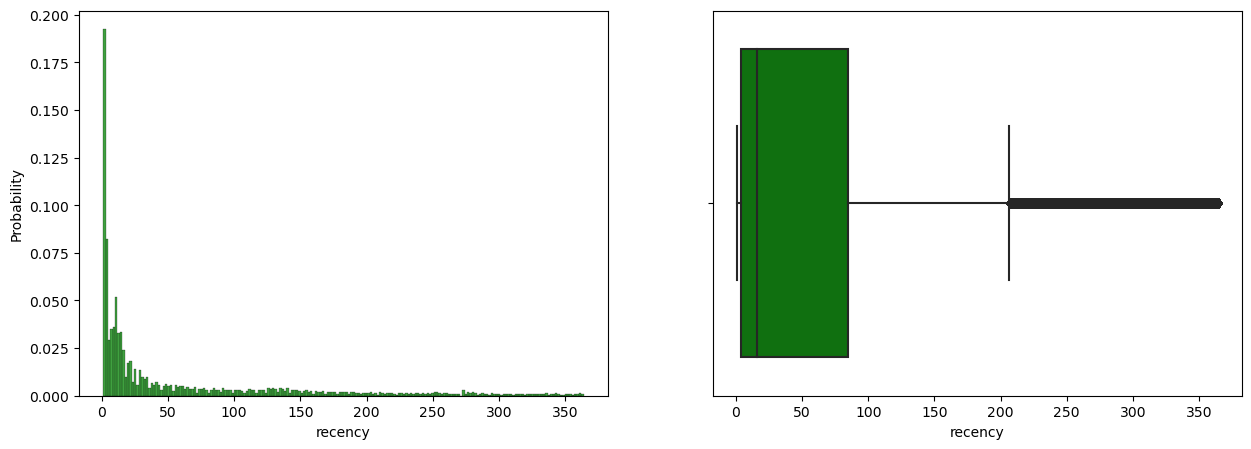

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
sns.histplot(ax=ax1, x=df.recency, stat='probability', color='green')
sns.boxplot(ax=ax2, x=df.recency, color='green')
plt.show()
plt.close()

The figures above show the distibution of monetary, frequency and recency for the dataset in which the top 1% of the data as been removed.\
It's clearly visible a drastic improvement of the quality of the plot. Most of the data is uniformely distribuited in plotting area.\
The largest monetary value has dropped by two orders of magnitude, the largest frequency is now 200 (which correspond to clients visiting the store a little more than 3 times per week) and the recency IQR is between 1 and 90, with a median of 16.

## Data cleaning
As the percentile based outlier removel revealed to be promising we proceed with the data cleaning process using that criterion.\
New dataframe with 99th percentile of the orginal data.

In [15]:
df_99 = df[ (df['monetary'] < np.percentile(df.monetary, QTL)) & (df['frequency'] < np.percentile(df.frequency, QTL))]
# df_99 = df[ df['frequency'] < np.percentile(df.frequency, QTL)]


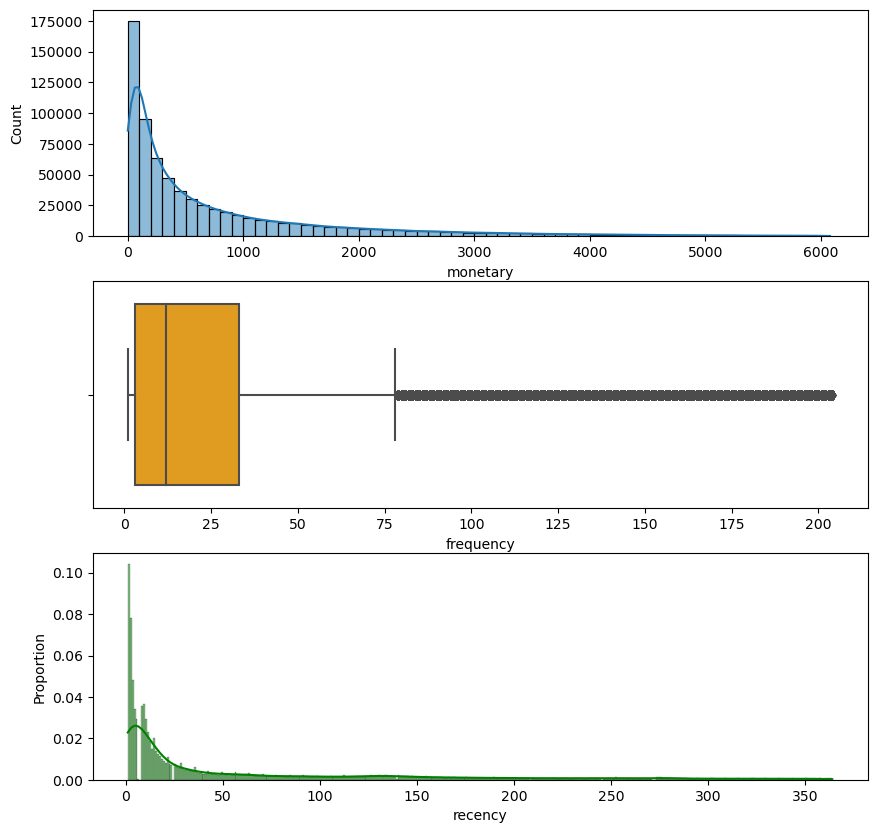

In [16]:
fig, axes = plt.subplots(3,1, figsize=(10,10))
sns.histplot(ax=axes[0], x=df_99['monetary'],
            kde=True,
            binwidth = 100)

sns.boxplot(ax=axes[1], x=df_99['frequency'], color='orange')

sns.histplot(ax=axes[2], x=df_99['recency'],
            kde=True,
            binwidth = 1,
            stat='proportion',
            color='green')
plt.show()
plt.close()

In [17]:
# . Presentare DB
# . Mettere a posto DB (convertire string to datetime)... volendo anche no, ma perche no?
# . Data exploration. e.g. info, describe, min, max
# . Preliminary data visualization (qdp with all points)
# . lineplot, hist plot box plot showing the propblems. Outlies due to heavily skewed DB
# . Actual data cleaning based on the percentiles. cutoff values 99%
# . New plot RFM (clean) and comparison with old one (all)

# . Clusterization
# . 2D RFM plot with monetary as color...maybe
# . PCA for a cleaner 2D plot
# . Color-code RFM so to easily distinguish them on plots as you scroll through figures
# . Cluster analysis based on percentiles. How many? How good they are...
# . Discuss pros and cons
# . Comparison with other clients (databases a and c). Are there similar patterns?

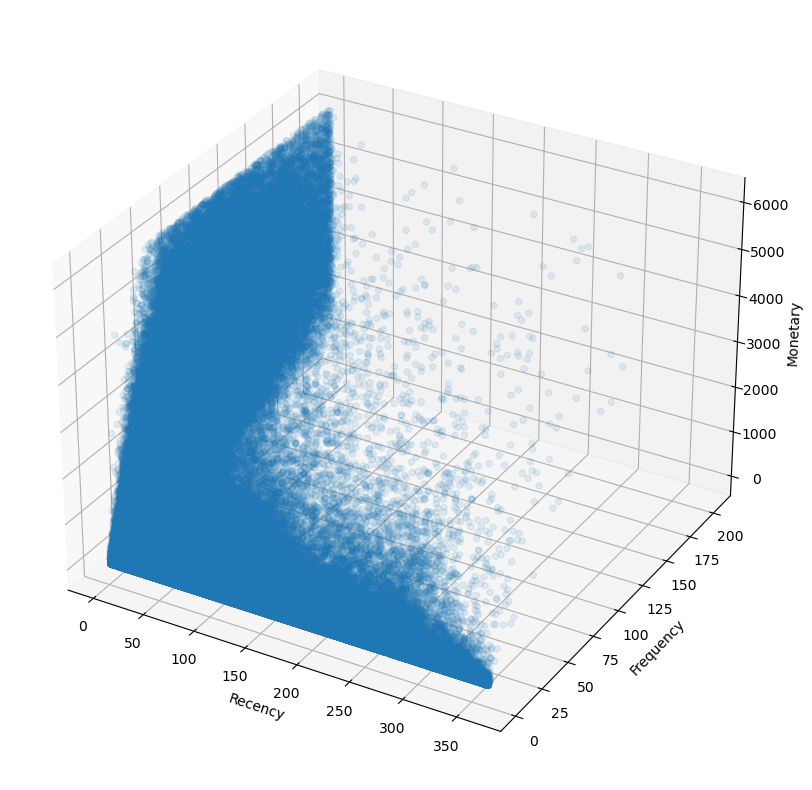

In [18]:
# sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(df_99['recency'], df_99['frequency'], df_99['monetary'], alpha=0.1)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.show()
plt.close()

Recency, Frequency and monetary are the parameters used to calculate the RFM score, it is important to explore thei mutual reletionships.

In [19]:
# fig, axes = plt.subplots(3,1, figsize=(10, 12))

# axes[0].plot(df_99["frequency"], df_99["monetary"], '.', alpha=.1)
# axes[0].set(xlabel='Frequency', ylabel="Monetary [€]")

# axes[1].plot(df_99["recency"], df_99["frequency"], '.', alpha=.1, color = 'orange')
# axes[1].set(xlabel='Recency', ylabel="Frequency")

# axes[2].plot(df_99["recency"], df_99["monetary"], '.', alpha=.1)
# axes[2].set(xlabel='Recency', ylabel="Monetary [€]")

# plt.show()
# plt.close()

In [20]:
df[['monetary', 'frequency']][ ~(df['monetary'] > np.percentile(df.monetary, 99))  & ~(df['frequency'] > np.percentile(df.frequency, 99))]

monetary  frequency
1          38.83          1
2          29.76          4
3        3052.51         56
4         896.14         16
5         119.10          2
...          ...        ...
725857   3863.78         59
725858    155.32          7
725859    142.98          8
725860    922.83         43
725861    371.92         33

[713852 rows x 2 columns]

In [21]:
df_99['monetary'].sort_values(ascending=False)
# df_99 = df_99[df_99['monetary'] > 1]
# We can see that later....

244708    6079.27
53777     6078.66
49941     6078.01
135411    6077.75
69695     6077.70
           ...   
414037       0.02
424216       0.02
70627        0.02
326715       0.02
466660       0.01
Name: monetary, Length: 713744, dtype: float64

## RFM SCORE
In the following section the RFM score, a class based identification of the parameter based on the subdivison of the group into five equipopapaled classes.


In [22]:
def assign_quantile(n):
    if n <= qtl[0]: return '1'
    if (n > qtl[0]) & (n <= qtl[1]): return '2'
    if (n > qtl[1]) & (n <= qtl[2]): return '3'
    if (n > qtl[2]) & (n <= qtl[3]): return '4'
    else: return '5'


qtl = np.percentile(df_99['recency'] *-1, [20, 40, 60, 80])
r = df_99['recency'].apply(lambda x: -1 * x).apply(assign_quantile)

qtl = np.percentile(df_99['frequency'], [20, 40, 60, 80])
f = df_99['frequency'].apply(assign_quantile)

qtl = np.percentile(df_99['monetary'], [20, 40, 60, 80])
m = df_99['monetary'].apply(assign_quantile)



In [23]:
# df_99['rfm_score'] = r + f + m
df_99 = df_99.assign(rfm_score= r + f + m)
df_99['rfm_score']

1         111
2         121
3         455
4         334
5         212
         ... 
725857    355
725858    222
725859    132
725860    454
725861    343
Name: rfm_score, Length: 713744, dtype: object

In [24]:
df_99.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 713744 entries, 1 to 725861
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   codice_cliente  713744 non-null  int64         
 1   recency         713744 non-null  int64         
 2   frequency       713744 non-null  int64         
 3   monetary        713744 non-null  float64       
 4   tmin            713744 non-null  float64       
 5   tmax            713744 non-null  float64       
 6   tmed            713744 non-null  float64       
 7   tdev            629389 non-null  float64       
 8   dt_min          713744 non-null  datetime64[ns]
 9   dt_max          713744 non-null  datetime64[ns]
 10  t_days_op       713744 non-null  int64         
 11  rfm_score       713744 non-null  object        
dtypes: datetime64[ns](2), float64(5), int64(4), object(1)
memory usage: 70.8+ MB


In [25]:
df_99.groupby(['recency'])['recency'].count().sort_values(ascending=False).head(20)

recency
1     74360
2     55745
3     34375
9     26003
8     25291
4     24262
10    20781
5     20775
11    16588
14    14235
12    13435
13    10420
15    10035
16     8975
17     8252
21     7803
18     7083
19     6524
28     5765
20     5756
Name: recency, dtype: int64

In [26]:
np.unique(df_99['rfm_score'])

array(['111', '112', '113', '114', '115', '121', '122', '123', '124',
       '125', '131', '132', '133', '134', '135', '141', '142', '143',
       '144', '145', '152', '153', '154', '155', '211', '212', '213',
       '214', '221', '222', '223', '224', '225', '231', '232', '233',
       '234', '235', '241', '242', '243', '244', '245', '251', '252',
       '253', '254', '255', '311', '312', '313', '314', '315', '321',
       '322', '323', '324', '325', '331', '332', '333', '334', '335',
       '341', '342', '343', '344', '345', '352', '353', '354', '355',
       '411', '412', '413', '414', '415', '421', '422', '423', '424',
       '425', '431', '432', '433', '434', '435', '441', '442', '443',
       '444', '445', '452', '453', '454', '455', '511', '512', '513',
       '514', '521', '522', '523', '524', '525', '531', '532', '533',
       '534', '535', '541', '542', '543', '544', '545', '552', '553',
       '554', '555'], dtype=object)

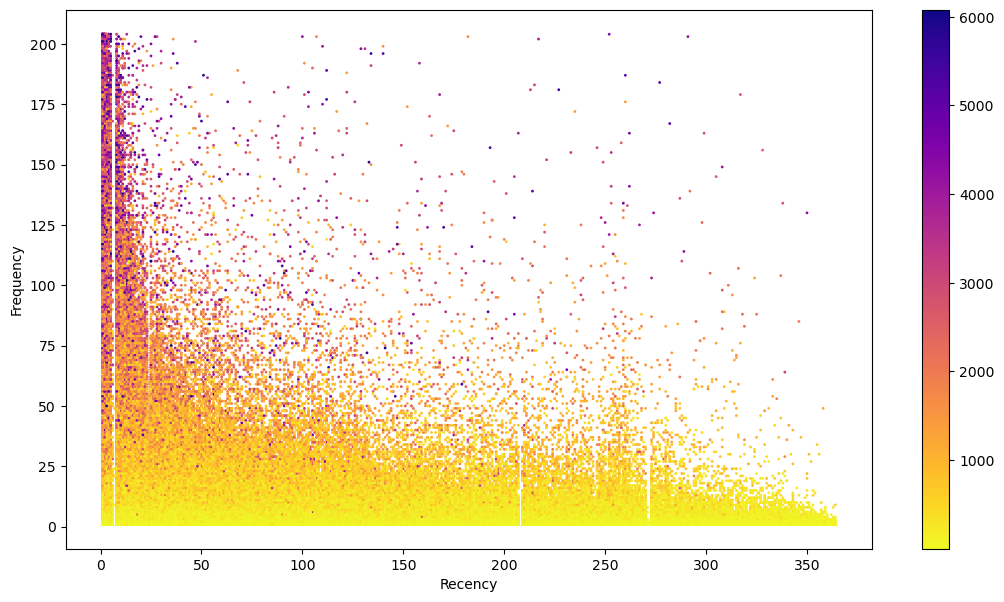

In [27]:
fig, axes = plt.subplots(figsize=(13, 7))
points = axes.scatter( df_99['recency'], df_99['frequency'], c=df_99['monetary'], s=1, cmap='plasma_r')
cbar = fig.colorbar(points)
axes.set_ylabel("Frequency")
axes.set_xlabel("Recency")
plt.show()
plt.close()

In [28]:
df_99

codice_cliente  recency  frequency  monetary   tmin    tmax  \
1                39020      288          1     38.83  38.83   38.83   
2                39026      205          4     29.76   4.42   11.50   
3                39032       10         56   3052.51   6.01  166.23   
4                39037       29         16    896.14  15.51  102.37   
5                39045       92          2    119.10  28.27   90.83   
...                ...      ...        ...       ...    ...     ...   
725857         1858159       16         59   3863.78   5.88  123.58   
725858         1859096       40          7    155.32  12.17   41.33   
725859         1859688      180          8    142.98   1.24   52.02   
725860         1859864        5         43    922.83   2.58   44.81   
725861         1861455       19         33    371.92   2.19   95.87   

             tmed       tdev     dt_min     dt_max  t_days_op rfm_score  
1       38.830000        NaN 2021-03-19 2021-03-19          0       111  
2        7.440000   3.107893 2021-02-06 2021-06-10        124       121  
3       54.509107  32.959800 2021-01-05 2021-12-22        351       455  
4       56.008750  23.022172 2021-01-12 2021-12-03        325       334  
5       59.550000  44.236600 2021-06-27 2021-10-01         96       212  
...           ...        ...        ...        ...        ...       ...  
725857  65.487797  20.684622 2021-01-03 2021-12-16        347       355  
725858  22.188571   9.749072 2021-03-12 2021-11-22        255       222  
725859  17.872500  16.525796 2021-01-17 2021-07-05        169       132  
725860  21.461163   9.945084 2021-01-11 2021-12-27        350       454  
725861  11.270303  16.075178 2021-03-27 2021-12-13        261       343  

[713744 rows x 12 columns]

In [29]:
# looktable for customer identification
customer_lookup = {
    'Lost Customers': [111, 112, 121, 131,141,151],
    'Hibernating Customers': [332, 322, 233, 232, 223, 222, 132, 123, 122, 212, 211],
    'Cannot Lose Them': [155, 154, 144, 214,215,115, 114, 113],
    'At Risk': [255, 254, 245, 244, 253, 252, 243, 242, 235, 234, 225, 224, 153, 152, 145, 143, 142, 135, 134, 133, 125, 124],
    'About To Sleep': [331, 321, 312, 221, 213, 231, 241, 251],
    'New Attention': [535, 534, 443, 434, 343, 334, 325, 324],
    'Promising': [525, 524, 523, 522, 521, 515, 514, 513, 425,424, 413,414,415, 315, 314, 313],
    'New Customers': [512, 511, 422, 421, 412, 411, 311],
    'Potential Loyalist': [553, 551, 552, 541, 542, 533, 532, 531, 452, 451, 442, 441, 431, 453, 433, 432, 423, 353, 352, 351, 342, 341, 333, 323],
    'Loyal' : [ 543, 444, 435, 355, 354, 345, 344, 335],
    'Champions': [555, 554, 544, 545, 454, 455, 445]}


# Create group columns and popolate it with 0 and hashset
df_99['group'] = 0

def assign_class(rfm_score):
    for key in customer_lookup:
        if int(rfm_score) in customer_lookup[key]:
            return key
    return

df_99['group'] = df_99['rfm_score'].apply(assign_class)

# Encode ordinal categorical variable
from pandas.api.types import CategoricalDtype
cat = CategoricalDtype(categories=customer_lookup.keys(), ordered=True)
df_99['group'] = df_99['group'].astype(cat)

In [30]:
# fig, axes = plt.subplots(1,2 ,figsize=(15, 7))
# points = axes[1].scatter( df_99['recency'], df_99['frequency'], c=df_99['monetary'], s=1, cmap='plasma_r')
# cbar = fig.colorbar(points)
# axes[1].set_ylabel("Frequency")
# axes[1].set_xlabel("Recency")
# sns.scatterplot(ax=axes[0], data=df_99, x='recency', y='frequency', hue='group', palette='nipy_spectral', markers='.')
# plt.show()
# plt.close()

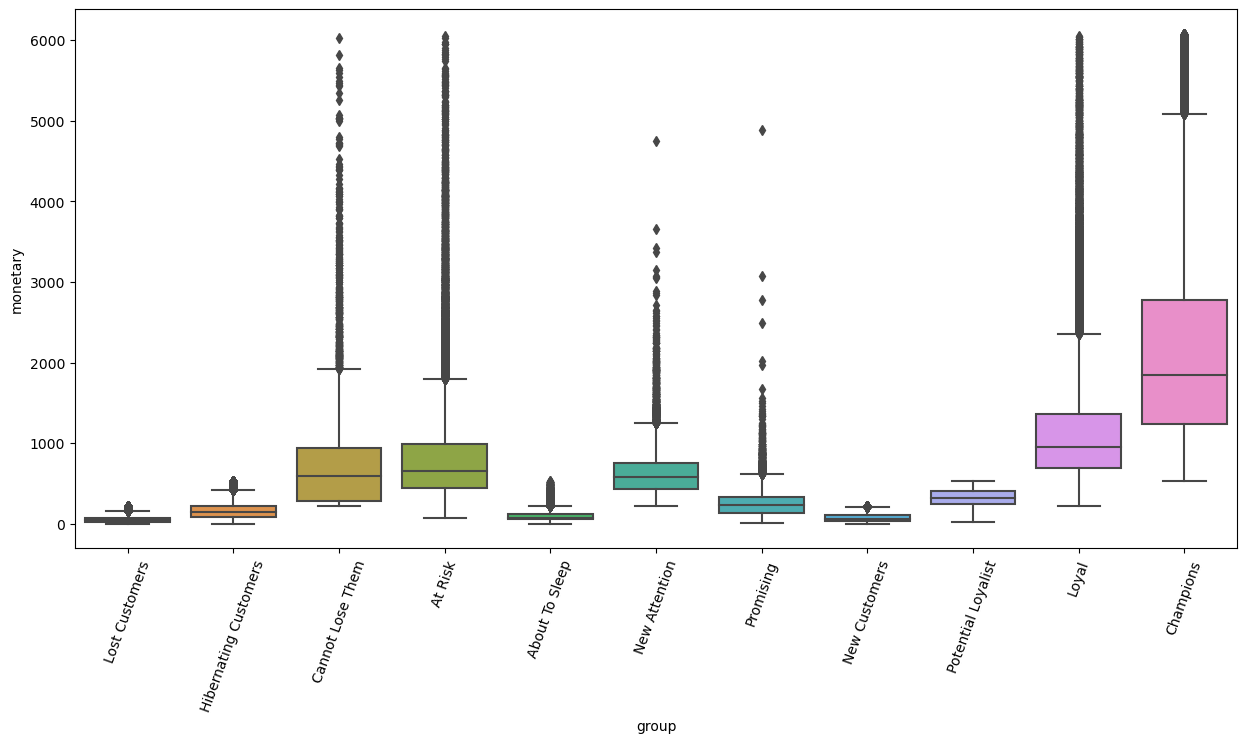

In [31]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.boxplot(ax=ax, data=df_99, x="group", y="monetary")
ax.set_xticklabels(cat.categories, rotation=70)
plt.show()
plt.close()

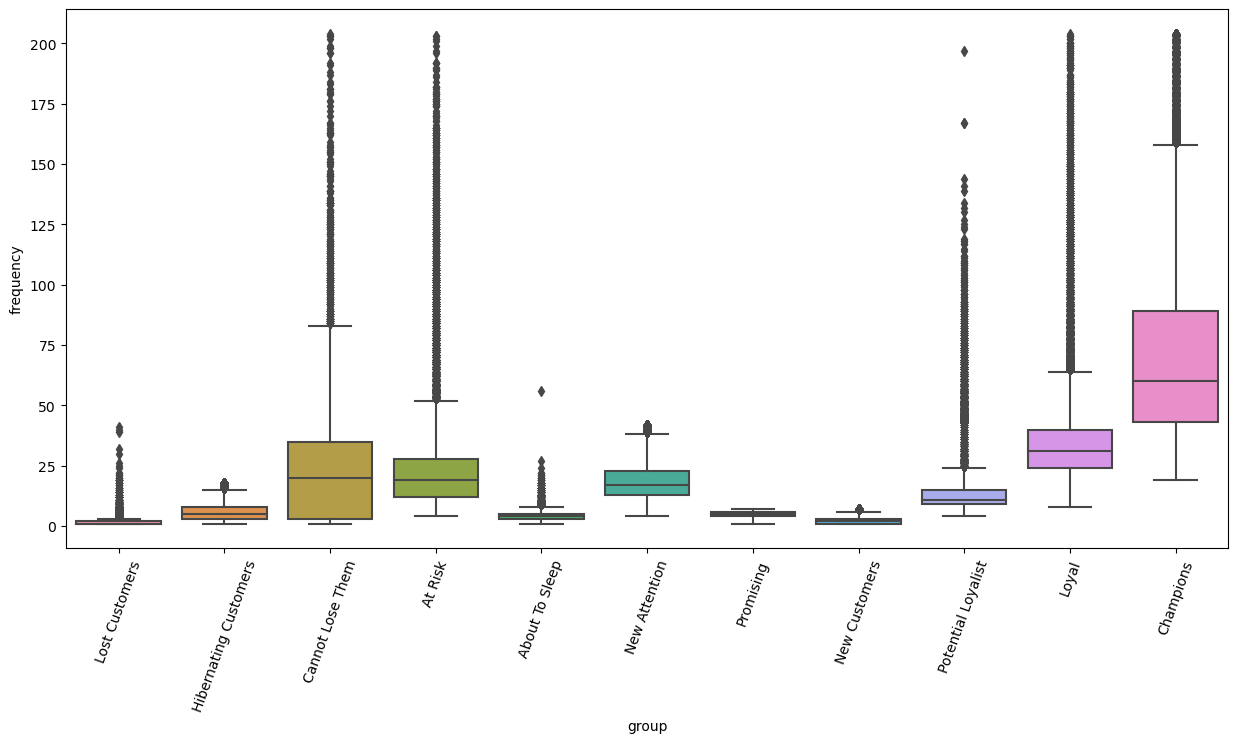

In [32]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.boxplot(ax=ax, data=df_99, x="group", y="frequency")
ax.set_xticklabels(cat.categories, rotation=70)
plt.show()
plt.close()

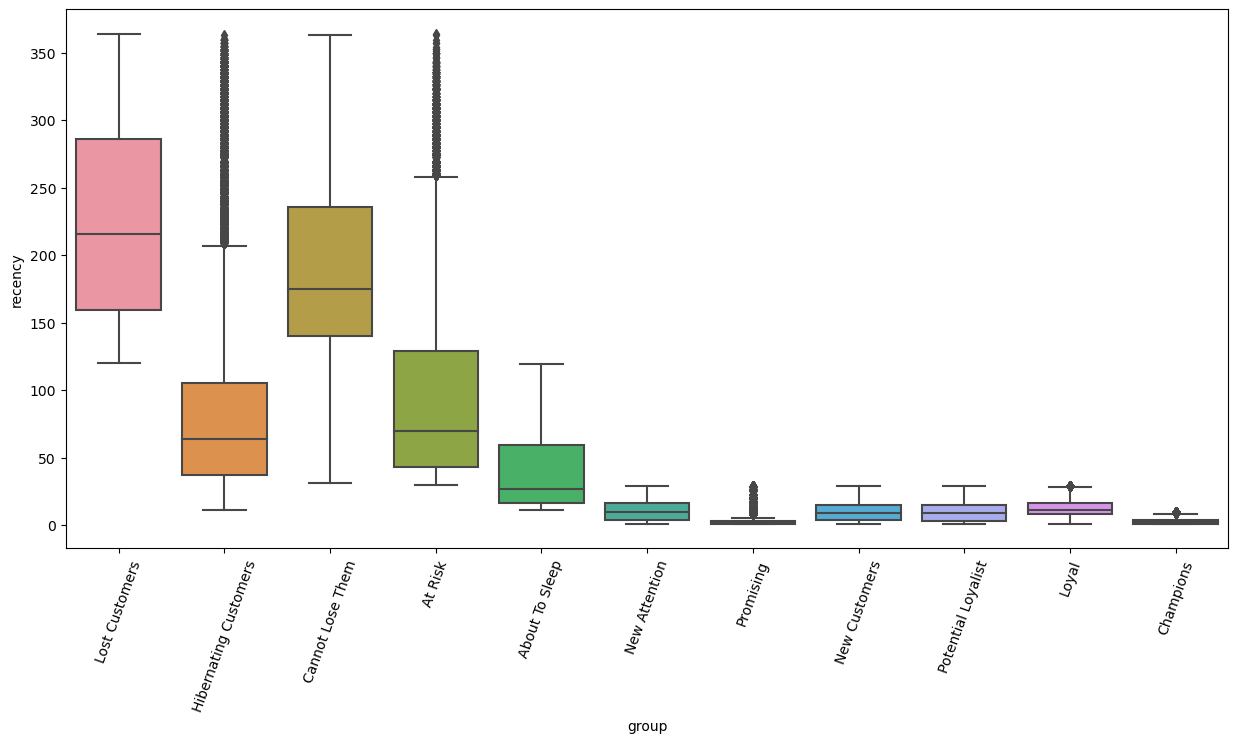

In [33]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.boxplot(ax=ax, data=df_99, x="group", y="recency")
ax.set_xticklabels(cat.categories, rotation=70)
plt.show()
plt.close()

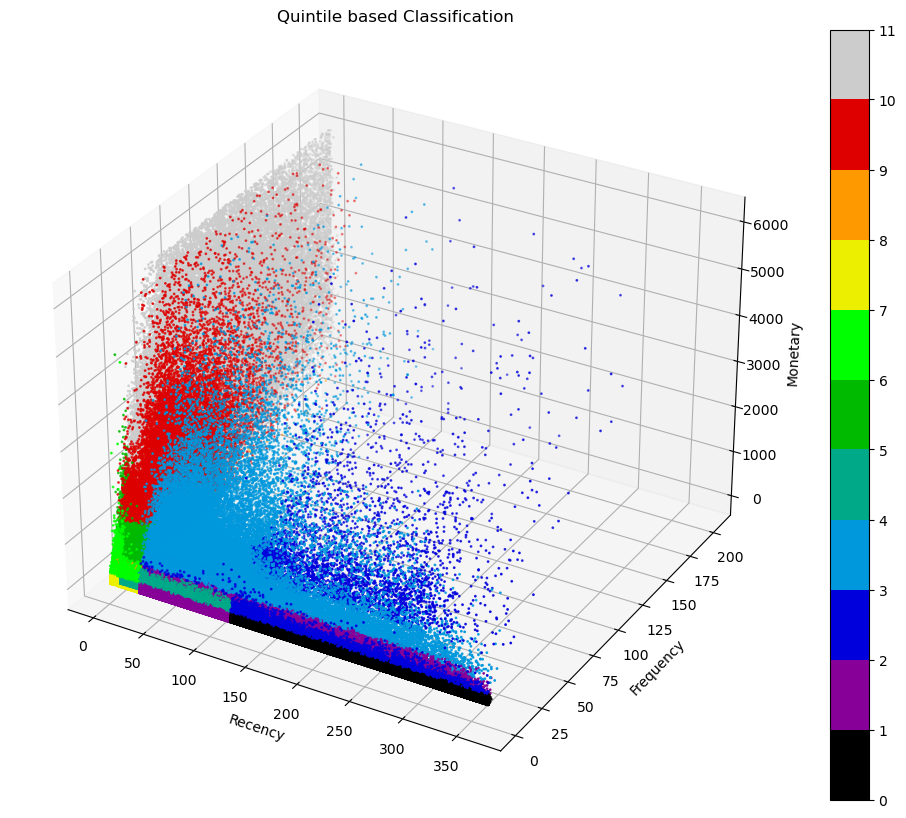

In [124]:
# sns.set_style("whitegrid", {'axes.grid' : False})
import matplotlib.colors as colors


fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection = '3d')
bounds = list(range(0,12))
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
points = ax.scatter(df_99['recency'], df_99['frequency'], df_99['monetary'], s=1, c=df_99['group'].cat.codes, cmap = 'nipy_spectral', norm=norm)
# cbar = fig.colorbar(points, orientation='vertical')

cbar = fig.colorbar(points, orientation='vertical', ticks=bounds)
# cbar.ax.set_yticklabels(df_99['group'].cat.categories) 

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('Quintile based Classification')
# fig.colorbar(pcm, ax=ax[3], orientation='vertical')
plt.show()
plt.close()

In [122]:
print((df_99['group'].cat.categories))
print(sorted(df_99['group'].cat.codes.unique()))
print(bounds)


Index(['Lost Customers', 'Hibernating Customers', 'Cannot Lose Them',
       'At Risk', 'About To Sleep', 'New Attention', 'Promising',
       'New Customers', 'Potential Loyalist', 'Loyal', 'Champions'],
      dtype='object')
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [35]:
# # Shitty customers
# shitty = df_99[df_99['monetary'] < 100]
# fig, axes = plt.subplots(figsize=(13,7))
# points = axes.scatter( shitty['recency'], shitty['frequency'], c=shitty['monetary'], s=1, cmap='plasma_r')
# cbar = fig.colorbar(points)
# axes.set_ylabel("Frequency")
# axes.set_xlabel("Recency")

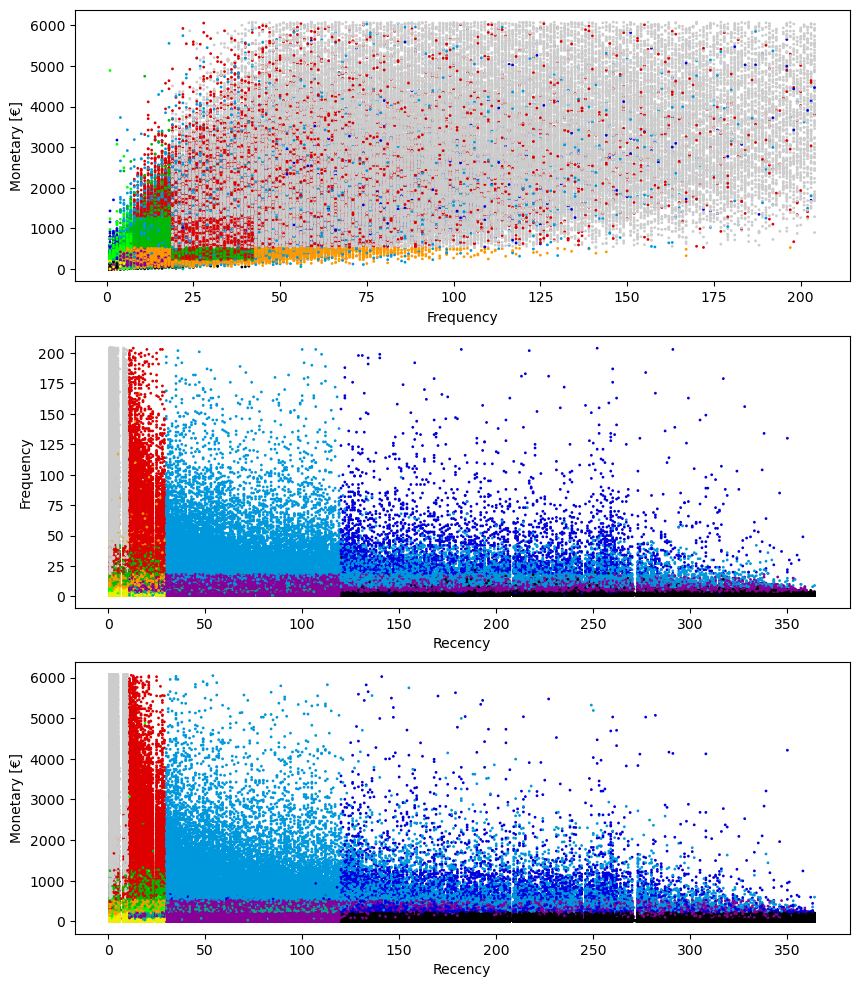

In [36]:
fig, axes = plt.subplots(3,1, figsize=(10, 12))

axes[0].scatter(df_99["frequency"], df_99["monetary"], s=1, c=df_99['group'].cat.codes, cmap = 'nipy_spectral', norm=norm)
axes[0].set(xlabel='Frequency', ylabel="Monetary [€]"),

axes[1].scatter(df_99["recency"], df_99["frequency"], s=1,  c=df_99['group'].cat.codes, cmap = 'nipy_spectral', norm=norm)
axes[1].set(xlabel='Recency', ylabel="Frequency")

axes[2].scatter(df_99["recency"], df_99["monetary"], s=1, c=df_99['group'].cat.codes, cmap = 'nipy_spectral', norm=norm)
axes[2].set(xlabel='Recency', ylabel="Monetary [€]"),

plt.show()
plt.close()

In [37]:
rfm_group = df_99.groupby(['group'])['group'].count().sort_values(ascending=False)
rfm_group.index

rfm_group

group
Champions                154221
Hibernating Customers    150928
Lost Customers            97278
Loyal                     75154
Potential Loyalist        71416
At Risk                   45812
New Attention             45074
New Customers             36980
About To Sleep            20565
Promising                  9172
Cannot Lose Them           7144
Name: group, dtype: int64

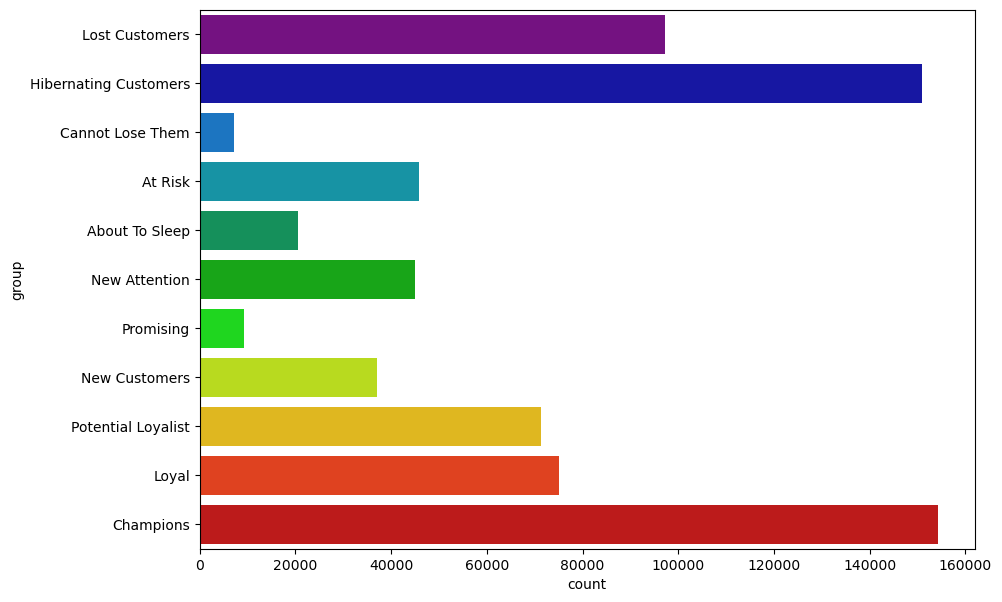

In [127]:
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(ax=ax, y=df_99["group"],palette = 'nipy_spectral')
plt.show()

## Normalized plots

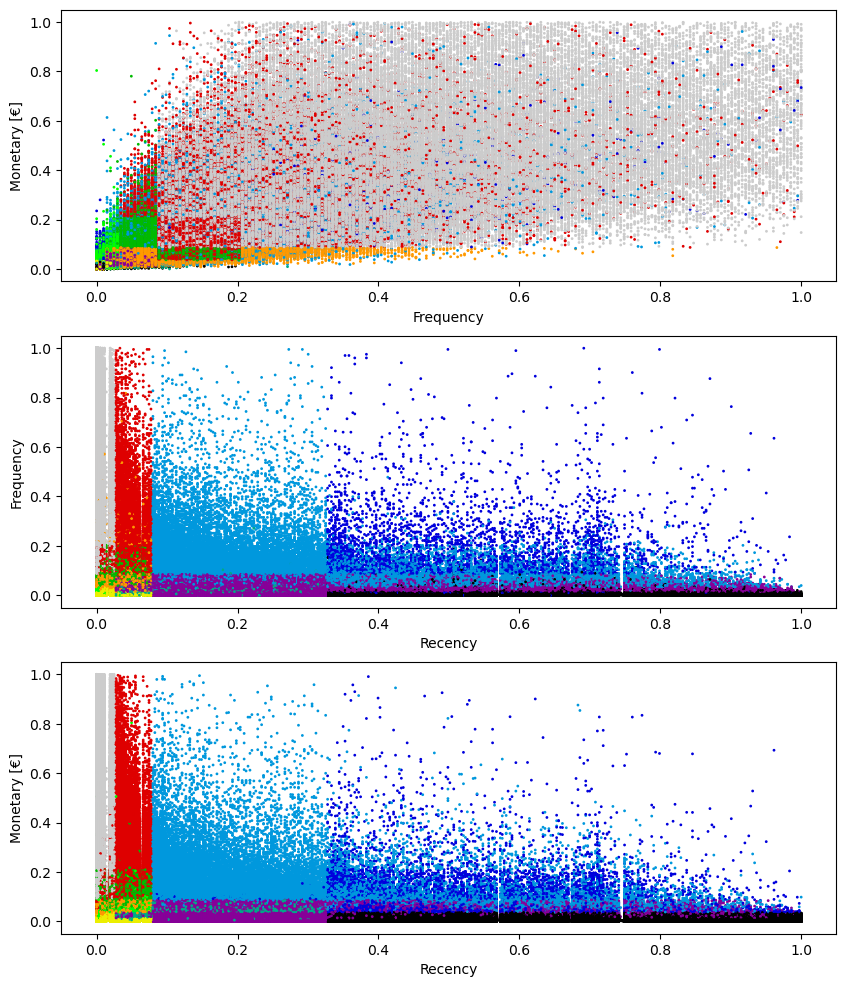

In [39]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df_99[['monetary', 'frequency', 'recency']])
# print(scaler.fit(df_99[['monetary', 'frequency', 'recency']]))
# print(scaler.data_max_)
data = (scaler.transform(df_99[['monetary', 'frequency', 'recency']]))
data[:,0]

fig, axes = plt.subplots(3,1, figsize=(10, 12))

axes[0].scatter(data[:,1], data[:,0], s=1, c=df_99['group'].cat.codes, cmap = 'nipy_spectral', norm=norm)
axes[0].set(xlabel='Frequency', ylabel="Monetary [€]")

axes[1].scatter(data[:,2], data[:,1], s=1,  c=df_99['group'].cat.codes, cmap = 'nipy_spectral', norm=norm)
axes[1].set(xlabel='Recency', ylabel="Frequency")

axes[2].scatter(data[:,2], data[:,0], s=1, c=df_99['group'].cat.codes, cmap = 'nipy_spectral', norm=norm)
axes[2].set(xlabel='Recency', ylabel="Monetary [€]")

plt.show()
plt.close()

## Evenly spaced interval based clusters
In this section instead of assigning the rfm score based upon the subdivion of R F and M into 5 section with the same population of points, we employ a subdivision based on the equal-distant clusters.

In [40]:
def assign_distance_score(value):
    if (value >= interval[0]) & (value < interval[1]):
        return '1'
    if (value >= interval[1]) & (value < interval[2]):
        return '2'
    if (value >= interval[2]) & (value < interval[3]):
        return '3'
    if (value >= interval[3]) & (value < interval[4]):
        return '4'
    else:
        return '5'
    
interval = -1 * (np.linspace(df_99['recency'].max(), df_99['recency'].min(), 6))
r_dist = df_99['recency'].apply(lambda x: -1 * x).apply(assign_distance_score)
    
interval = np.linspace(df_99['frequency'].min(), df_99['frequency'].max(), 6)
f_dist = df_99['frequency'].apply(assign_distance_score)

interval = np.linspace(df_99['monetary'].min(), df_99['monetary'].max(), 6)
m_dist = df_99['monetary'].apply(assign_distance_score)


In [41]:
# df_99['rfm_score'] = r + f + m
df_99 = df_99.assign(rfm_score_dist = r_dist + f_dist + m_dist)
df_99['rfm_score_dist']

1         211
2         311
3         523
4         511
5         411
         ... 
725857    524
725858    511
725859    311
725860    521
725861    511
Name: rfm_score_dist, Length: 713744, dtype: object

In [42]:
df_99['group_dist'] = df_99['rfm_score_dist'].apply(assign_class)
df_99['group_dist']

# Categorical encoding
cat = CategoricalDtype(categories=customer_lookup.keys(), ordered=True)
df_99['group_dist'] = df_99['group_dist'].astype(cat)

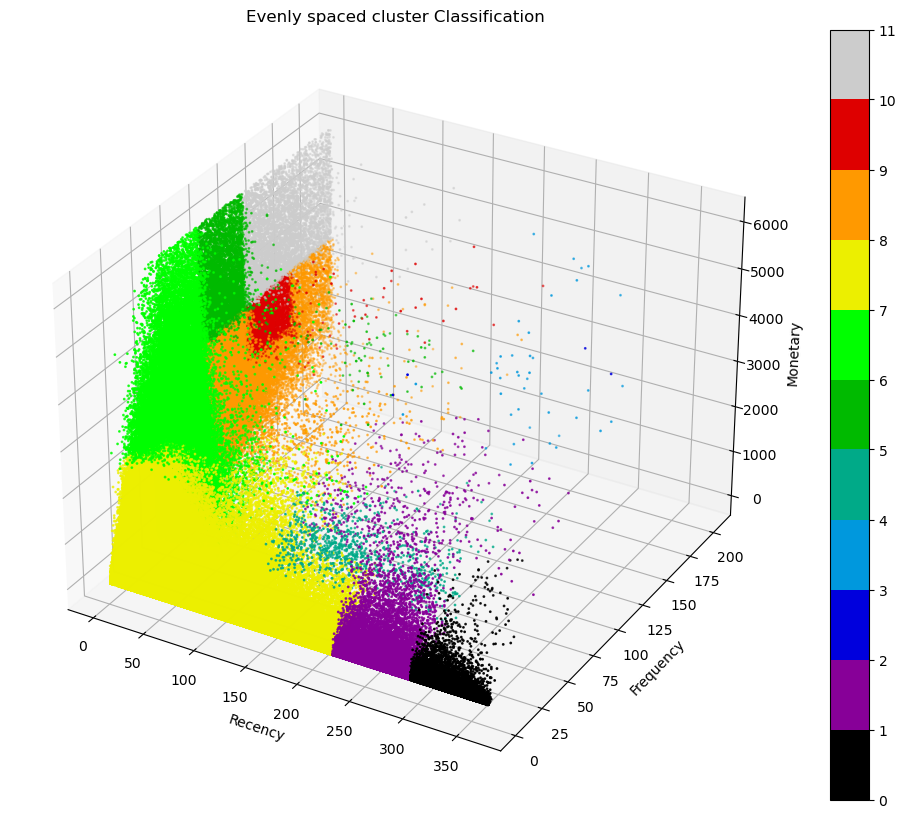

In [130]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection = '3d')
bounds = np.array(range(0,12))
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
# pcm = ax[1].pcolormesh(X, Y, Z, norm=norm, cmap='RdBu_r')
points = ax.scatter(df_99['recency'], df_99['frequency'], df_99['monetary'], s=1, c=df_99['group_dist'].cat.codes, cmap = 'nipy_spectral', norm=norm)
cbar = fig.colorbar(points, orientation='vertical', ticks=bounds)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('Evenly spaced cluster Classification')
# fig.colorbar(pcm, ax=ax[3], orientation='vertical')
plt.show()
plt.close()

## Fixed Interval classification

In [44]:
# Custom Intervals
custom_r = [7, 30, 90, 180]
custom_f = [24, 48, 96, 192]
custom_m = [1000, 2000, 4000, 10000]

In [45]:
def assign_custom_interval(n):
    if n <= interval[0]: return '1'
    if (n > interval[0]) & (n <= interval[1]): return '2'
    if (n > interval[1]) & (n <= interval[2]): return '3'
    if (n > interval[2]) & (n <= interval[3]): return '4'
    else: return '5'


interval = [x * -1 for x in custom_r][::-1]
r_cst = df_99['recency'].apply(lambda x: -1 * x).apply(assign_custom_interval)

interval = custom_f
f_cst = df_99['frequency'].apply(assign_custom_interval)

interval = custom_m
m_cst = df_99['monetary'].apply(assign_custom_interval)


In [46]:
df_99 = df_99.assign(rfm_score_cst = r_cst + f_cst + m_cst)
df_99[['recency', 'frequency', 'monetary']].describe()


recency      frequency       monetary
count  713744.000000  713744.000000  713744.000000
mean       61.238367      25.028322     768.628517
std        86.436380      32.759057    1016.991544
min         1.000000       1.000000       0.010000
25%         4.000000       3.000000     102.680000
50%        17.000000      12.000000     345.160000
75%        88.000000      33.000000    1016.680000
max       364.000000     204.000000    6079.270000

In [47]:
df_99['group_cst'] = df_99['rfm_score_cst'].apply(assign_class)

# Categorical encoding
cat = CategoricalDtype(categories=customer_lookup.keys(), ordered=True)
df_99['group_cst'] = df_99['group_cst'].astype(cat)

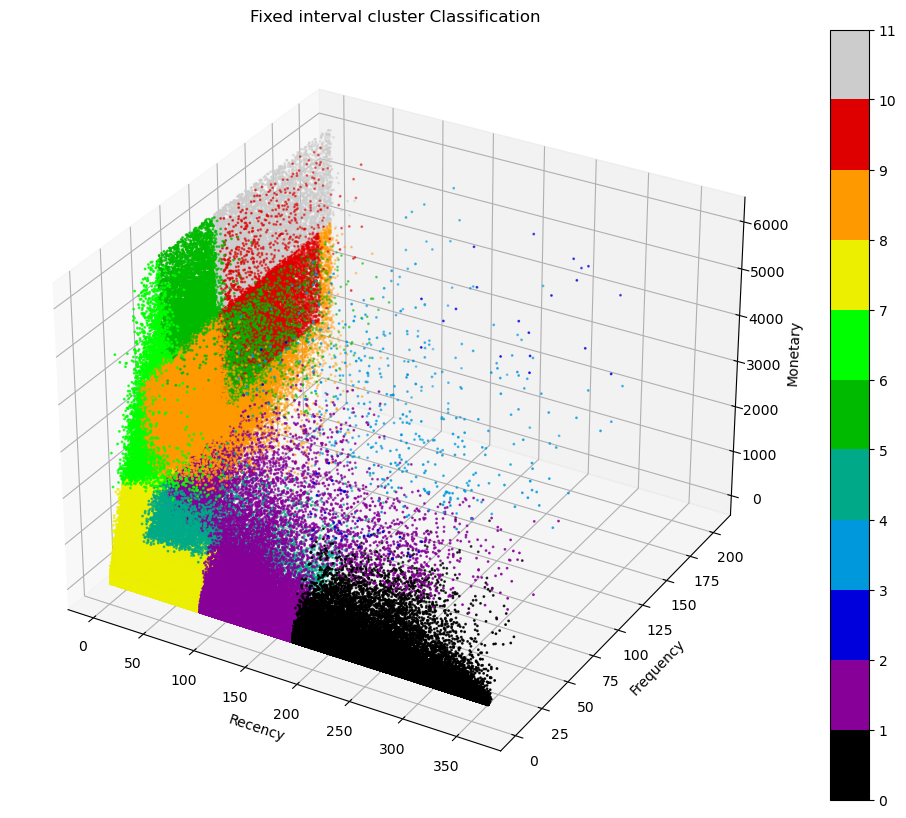

In [129]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection = '3d')
bounds = np.array(range(0,12))
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
# pcm = ax[1].pcolormesh(X, Y, Z, norm=norm, cmap='RdBu_r')
points = ax.scatter(df_99['recency'], df_99['frequency'], df_99['monetary'], s=1, c=df_99['group_cst'].cat.codes, cmap = 'nipy_spectral', norm=norm)
cbar = fig.colorbar(points, orientation='vertical', ticks=bounds)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('Fixed interval cluster Classification')
# fig.colorbar(pcm, ax=ax[3], orientation='vertical')
plt.show()
plt.close()

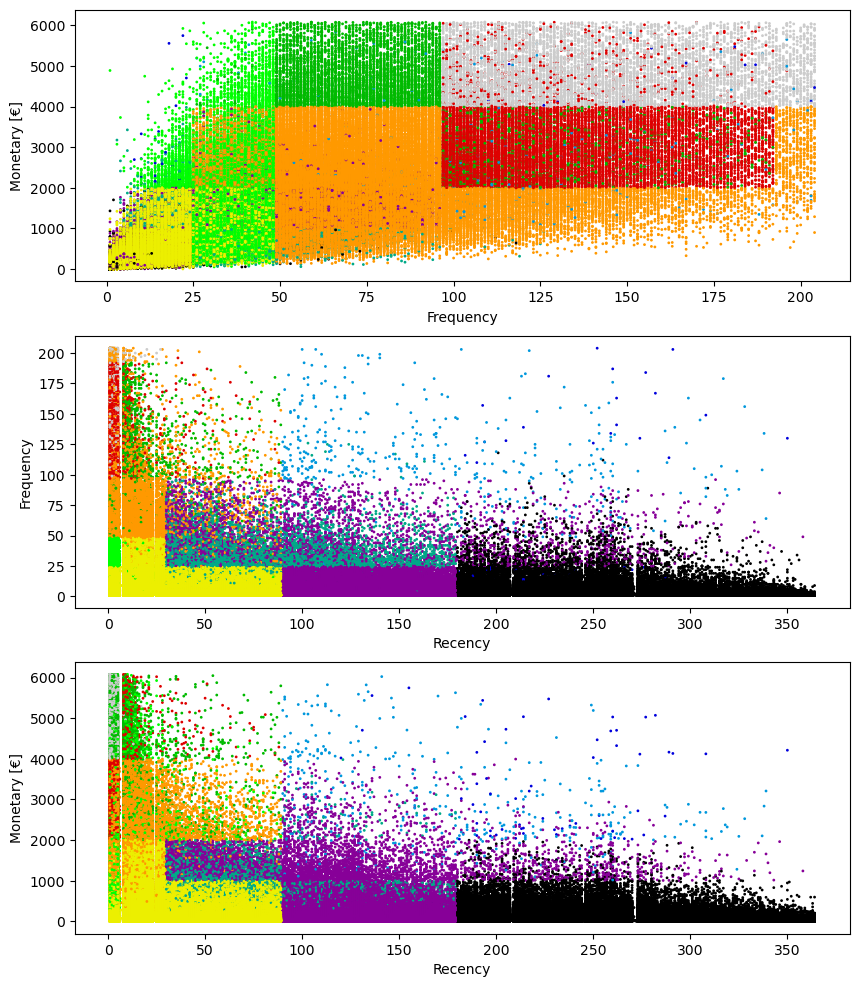

In [49]:
fig, axes = plt.subplots(3,1, figsize=(10, 12))

axes[0].scatter(df_99["frequency"], df_99["monetary"], s=1, c=df_99['group_cst'].cat.codes, cmap = 'nipy_spectral', norm=norm)
axes[0].set(xlabel='Frequency', ylabel="Monetary [€]"),

axes[1].scatter(df_99["recency"], df_99["frequency"], s=1,  c=df_99['group_cst'].cat.codes, cmap = 'nipy_spectral', norm=norm)
axes[1].set(xlabel='Recency', ylabel="Frequency")

axes[2].scatter(df_99["recency"], df_99["monetary"], s=1, c=df_99['group_cst'].cat.codes, cmap = 'nipy_spectral', norm=norm)
axes[2].set(xlabel='Recency', ylabel="Monetary [€]"),

plt.show()
plt.close()

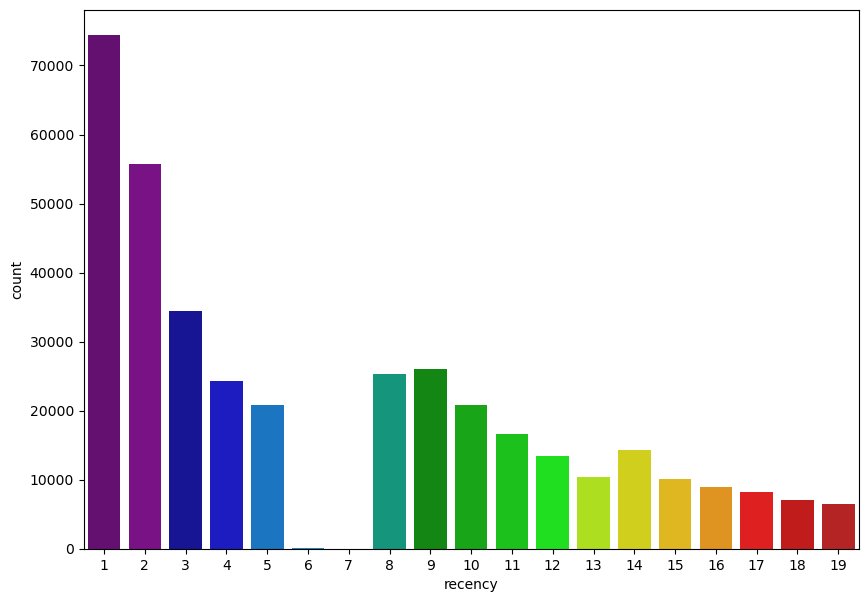

In [50]:
first_recency = df_99[df_99['recency'] < 20]
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(ax=ax, x=first_recency["recency"],palette = 'nipy_spectral')
plt.show()

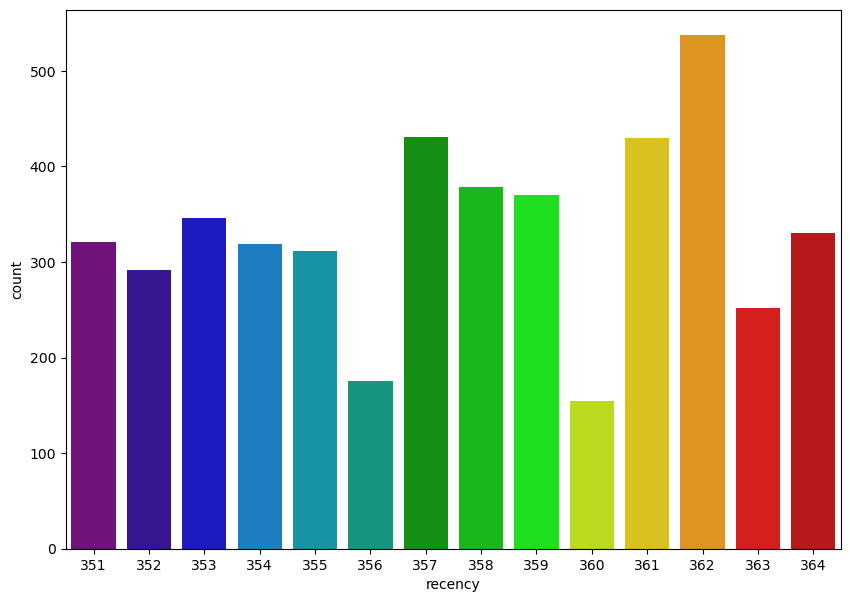

In [51]:
first_recency = df_99[df_99['recency'] > 350]
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(ax=ax, x=first_recency["recency"],palette = 'nipy_spectral')
plt.show()

In [52]:
df_99['group_cst'].cat.codes

1         0
2         0
3         8
4         7
5         1
         ..
725857    8
725858    7
725859    0
725860    6
725861    7
Length: 713744, dtype: int8

## KMEANS CLUSTER ANALYSIS

In [53]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia, silhouette = [], []
for i in range(1,12):
    print('Computing cluster with k={}'.format(i))
    kmeans = KMeans(n_clusters=i,random_state=0)
    y_pred = kmeans.fit_predict(data)
    inertia.append(kmeans.inertia_)


Computing cluster with k=1
Computing cluster with k=2
Computing cluster with k=3
Computing cluster with k=4
Computing cluster with k=5
Computing cluster with k=6
Computing cluster with k=7
Computing cluster with k=8
Computing cluster with k=9
Computing cluster with k=10
Computing cluster with k=11


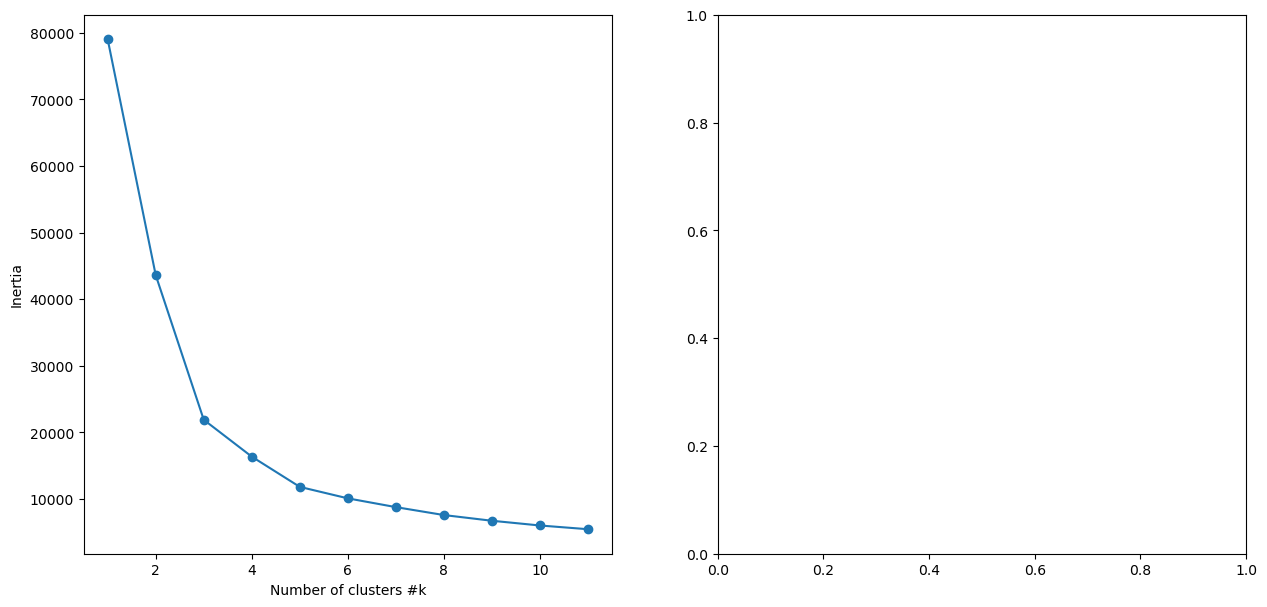

In [54]:
# Silhouette score is extremely slow and memeory demanding. Look more thoughroully into this.
fig, axes = plt.subplots(1,2, figsize=(15, 7))
axes[0].plot([*range(1, 12, 1)], inertia, '-o')
axes[0].set(xlabel='Number of clusters #k', ylabel="Inertia")
# axes[1].plot([*range(1, 12, 1)], silhouette, '-o')
# axes[1].set(xlabel='Number of clusters #k', ylabel="Silhouette Score")
plt.show()

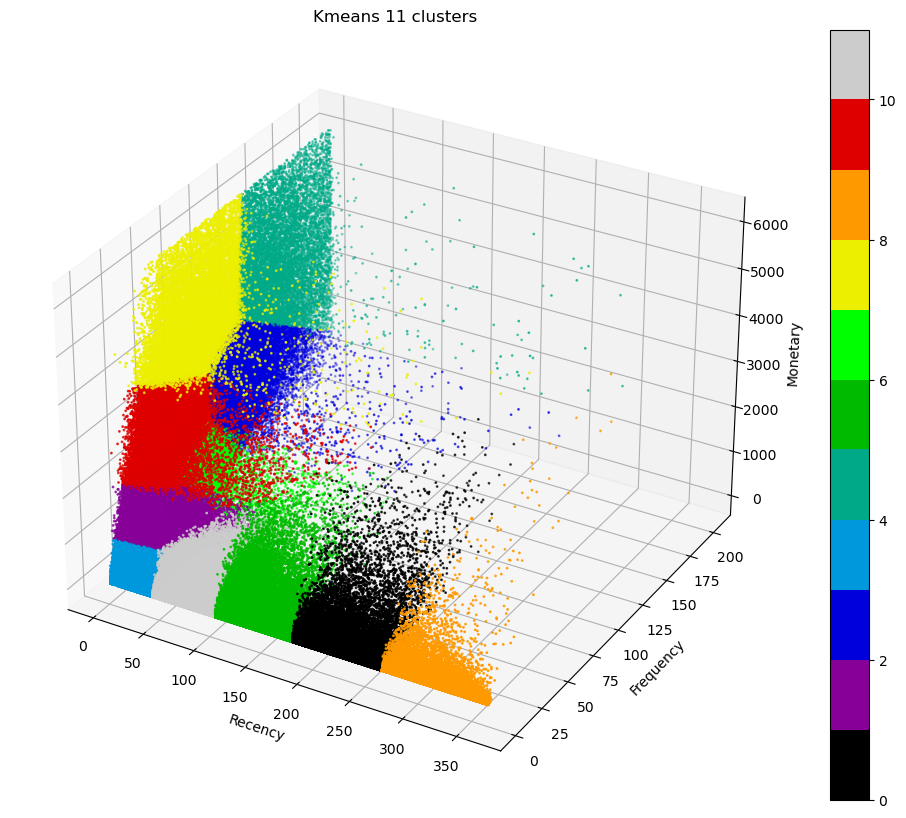

In [55]:
# 11 clusters division
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection = '3d')
bounds = np.array(range(0,12))
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
# pcm = ax[1].pcolormesh(X, Y, Z, norm=norm, cmap='RdBu_r')
points = ax.scatter(df_99['recency'], df_99['frequency'], df_99['monetary'], s=1, c=y_pred, cmap = 'nipy_spectral', norm=norm)
cbar = fig.colorbar(points, orientation='vertical')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('Kmeans 11 clusters')
# fig.colorbar(pcm, ax=ax[3], orientation='vertical')
plt.show()
plt.close()

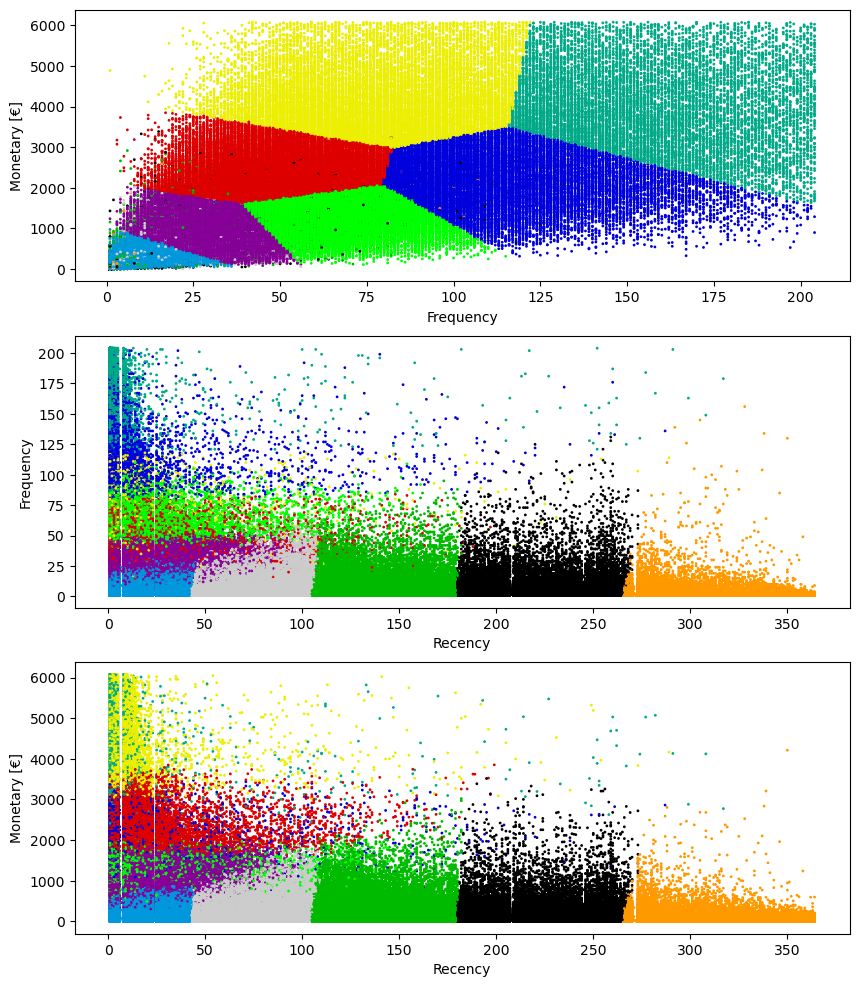

In [56]:
fig, axes = plt.subplots(3,1, figsize=(10, 12))

axes[0].scatter(df_99["frequency"], df_99["monetary"], s=1, c=y_pred, cmap = 'nipy_spectral', norm=norm)
axes[0].set(xlabel='Frequency', ylabel="Monetary [€]"),

axes[1].scatter(df_99["recency"], df_99["frequency"], s=1,  c=y_pred, cmap = 'nipy_spectral', norm=norm)
axes[1].set(xlabel='Recency', ylabel="Frequency")

axes[2].scatter(df_99["recency"], df_99["monetary"], s=1, c=y_pred, cmap = 'nipy_spectral', norm=norm)
axes[2].set(xlabel='Recency', ylabel="Monetary [€]"),

plt.show()
plt.close()

In [57]:
df_99['monetary'][ df_99['group'] == 'Lost Customers'].max()
df_99

codice_cliente  recency  frequency  monetary   tmin    tmax  \
1                39020      288          1     38.83  38.83   38.83   
2                39026      205          4     29.76   4.42   11.50   
3                39032       10         56   3052.51   6.01  166.23   
4                39037       29         16    896.14  15.51  102.37   
5                39045       92          2    119.10  28.27   90.83   
...                ...      ...        ...       ...    ...     ...   
725857         1858159       16         59   3863.78   5.88  123.58   
725858         1859096       40          7    155.32  12.17   41.33   
725859         1859688      180          8    142.98   1.24   52.02   
725860         1859864        5         43    922.83   2.58   44.81   
725861         1861455       19         33    371.92   2.19   95.87   

             tmed       tdev     dt_min     dt_max  t_days_op rfm_score  \
1       38.830000        NaN 2021-03-19 2021-03-19          0       111   
2        7.440000   3.107893 2021-02-06 2021-06-10        124       121   
3       54.509107  32.959800 2021-01-05 2021-12-22        351       455   
4       56.008750  23.022172 2021-01-12 2021-12-03        325       334   
5       59.550000  44.236600 2021-06-27 2021-10-01         96       212   
...           ...        ...        ...        ...        ...       ...   
725857  65.487797  20.684622 2021-01-03 2021-12-16        347       355   
725858  22.188571   9.749072 2021-03-12 2021-11-22        255       222   
725859  17.872500  16.525796 2021-01-17 2021-07-05        169       132   
725860  21.461163   9.945084 2021-01-11 2021-12-27        350       454   
725861  11.270303  16.075178 2021-03-27 2021-12-13        261       343   

                        group rfm_score_dist             group_dist  \
1              Lost Customers            211  Hibernating Customers   
2              Lost Customers            311          New Customers   
3                   Champions            523              Promising   
4               New Attention            511          New Customers   
5       Hibernating Customers            411          New Customers   
...                       ...            ...                    ...   
725857                  Loyal            524              Promising   
725858  Hibernating Customers            511          New Customers   
725859  Hibernating Customers            311          New Customers   
725860              Champions            521              Promising   
725861          New Attention            511          New Customers   

       rfm_score_cst              group_cst  
1                111         Lost Customers  
2                111         Lost Customers  
3                433     Potential Loyalist  
4                411          New Customers  
5                211  Hibernating Customers  
...              ...                    ...  
725857           433     Potential Loyalist  
725858           311          New Customers  
725859           111         Lost Customers  
725860           521              Promising  
725861           421          New Customers  

[713744 rows x 17 columns]

In [58]:
df_99.groupby(['group_dist'])['group_dist'].count().sort_values(ascending=False)

group_dist
New Customers            505528
Promising                 97344
Hibernating Customers     35221
Potential Loyalist        32091
Lost Customers            25364
Champions                  6524
New Attention              6406
Loyal                      4286
About To Sleep              934
At Risk                      42
Cannot Lose Them              4
Name: group_dist, dtype: int64

In [59]:
df_99.groupby(['group_cst'])['group_cst'].count().sort_values(ascending=False)

group_cst
New Customers            349176
Hibernating Customers     95051
Potential Loyalist        89884
Lost Customers            82361
Promising                 54372
Loyal                     16344
About To Sleep            10670
New Attention              8099
Champions                  7287
At Risk                     440
Cannot Lose Them             60
Name: group_cst, dtype: int64

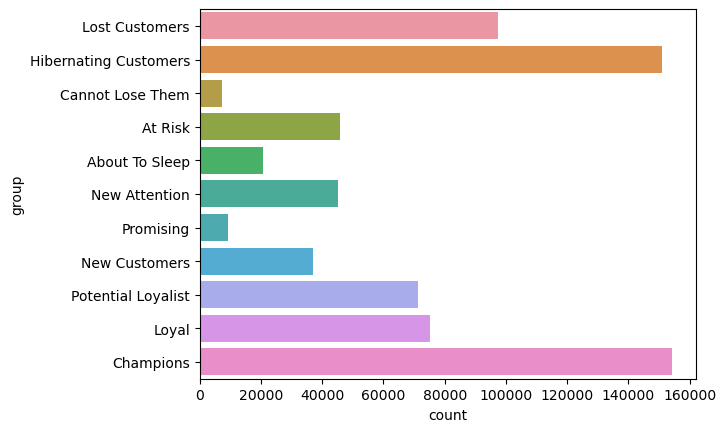

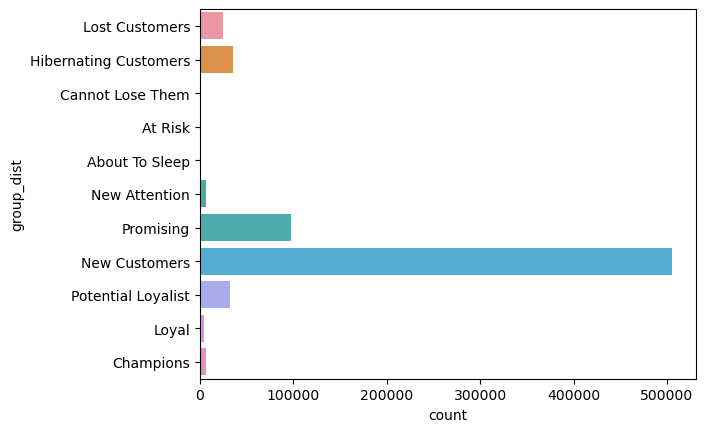

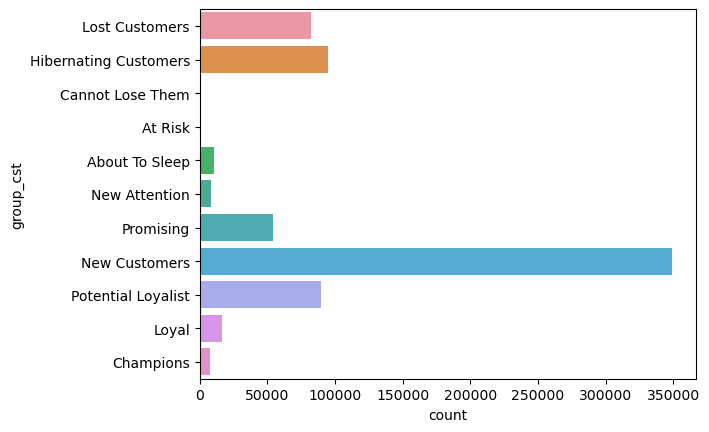

In [60]:
sns.countplot(data=df_99, y="group")
plt.show()
sns.countplot(data=df_99, y="group_dist")
plt.show()
sns.countplot(data=df_99, y="group_cst")
plt.show()